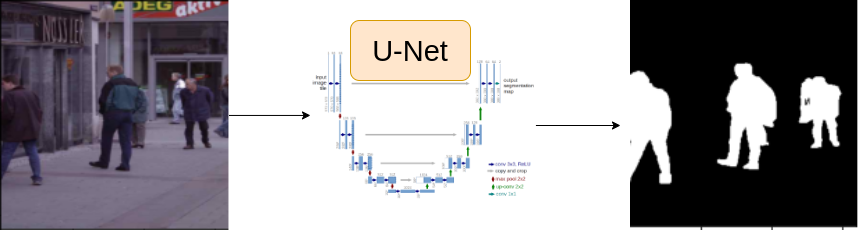

# Some Common Imports

In [50]:
import cv2
import gc
import sys
import torch
import numpy as np 
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split

In [51]:
def show_image(image, mask, pred_image = None):
    
    if pred_image == None:
        
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')
        
        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')
        
    elif pred_image != None :
        
        f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10,5))
        
        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')
        
        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')
        
        ax3.set_title('MODEL OUTPUT')
        ax3.imshow(pred_image.permute(1,2,0).squeeze(),cmap = 'gray')

# Task : 2 Setup Configurations

In [52]:
sys.path.append('\Deep learning project final')
DEVICE = 'cuda'
EPOCHS = 50
LR = 0.003
IMAGE_HEIGHT = 320
IMAGE_WIDTH = 320
BATCH_SIZE = 8
ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [53]:
df = pd.read_csv('train.csv')
df.head()

,masks,images
0,white masked images\0.png,training samples\0.jpg
1,white masked images\1.png,training samples\1.jpg
2,white masked images\10.png,training samples\10.jpg
3,white masked images\100.png,training samples\100.jpg
4,white masked images\101.png,training samples\101.jpg


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   masks   145 non-null    object
 1   images  145 non-null    object
dtypes: object(2)
memory usage: 2.4+ KB


In [55]:
row = df.iloc[25]

image_path = row.images
mask_path = row.masks
print(image_path)

image = cv2.imread(image_path)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

training samples\120.jpg


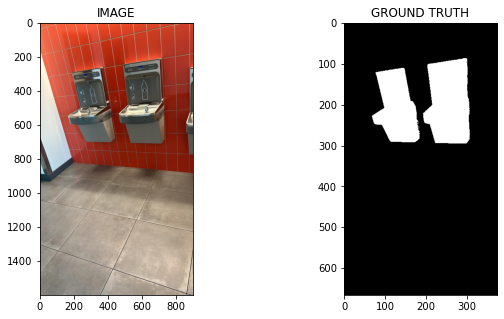

In [56]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [57]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Task 4 : Create Custom Dataset 

In [58]:
import torchvision
from torch.utils.data import Dataset
from torchvision.transforms import transforms

In [59]:
class SegmentationDataset(Dataset):
    
    def __init__(self, df):
        
        self.df=df
        self.transforms = transforms.Resize((IMAGE_WIDTH, IMAGE_HEIGHT))
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self ,idx):
        row = self.df.iloc[idx]
        image_path = row['images']
        mask_path = row['masks']
        
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) #(h,w, c)
        mask = np.expand_dims(mask, axis=-1) #(h,w,1)
        
        #(h,w,c) -> (c,h,w)
        image = np.transpose(image ,(2,0,1)).astype(np.float32)
        mask = np.transpose(mask ,(2,0,1)).astype(np.float32)
        
        original_image = self.transforms(torch.Tensor(image))
        original_image = original_image/255
        masked_image = self.transforms(torch.Tensor(mask))
        
        masked_image = torch.round(masked_image/255.0)
        
        return original_image, masked_image


In [13]:
trainset = SegmentationDataset(train_df)
validset = SegmentationDataset(valid_df)


In [14]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 116
Size of Validset : 29


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


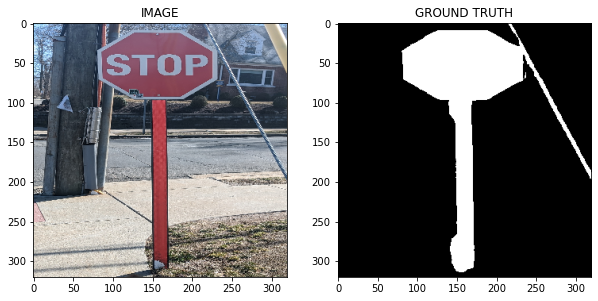

In [15]:
idx = 44
image, mask = trainset[idx]
show_image(image, mask)

# Task 5 : Load dataset into batches

In [16]:
from torch.utils.data import DataLoader


In [17]:
trainloader = DataLoader(trainset , batch_size =BATCH_SIZE , shuffle =True )
validloader = DataLoader(validset , batch_size =BATCH_SIZE  )

In [18]:
print(f"total no,of batches in trainloader: {len(trainloader)}")
print(f"total no,of batches in validloader: {len(validloader)}")

total no,of batches in trainloader: 15
total no,of batches in validloader: 4


In [19]:
for image , mask in trainloader:
    break
print (f'One batch image shape: {image.shape}')
print (f'One batch image shape: {mask.shape}')

One batch image shape: torch.Size([8, 3, 320, 320])
One batch image shape: torch.Size([8, 1, 320, 320])


# Task 6 : Create Segmentation Model

In [20]:
from torch import nn 
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss


In [21]:
class SegmentationModel (nn.Module):
    def __init__(self):
        super (SegmentationModel , self).__init__()

        self.arc = smp.Unet(
            encoder_name= ENCODER ,
            encoder_weights=  WEIGHTS ,
            in_channels= 3 ,
            classes=  1 ,
            activation = None
        )

    def forward(self, images, masks=None):
        logits = self.arc(images)

        if masks is not None:
            loss1 = DiceLoss(mode='binary')(logits, masks)
            loss2 = nn.BCEWithLogitsLoss()(logits, masks)
            return logits, loss1+loss2
        return logits


In [22]:
model = SegmentationModel()
model.to(DEVICE)

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
           

# Task 7 : Create Train and Validation Function 

In [23]:
def train_fn (data_loader , model , optimizer):
    model.train()
    total_loss =0.0

    for images, masks in tqdm(data_loader) :

        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        optimizer.zero_grad()
        logits , loss = model(images ,masks)
        loss.mean().backward()
        optimizer.step()

        total_loss += loss.mean().item()
        del logits
        del loss
        gc.collect()
        torch.cuda.empty_cache()

    return total_loss / len(data_loader)

In [24]:
def eval_fn (data_loader , model ):
    model.eval()
    total_loss =0.0
    with torch.no_grad():
        for images, masks in tqdm(data_loader):

            images = images.to(DEVICE)
            masks = masks.to(DEVICE)

            logits , loss = model(images ,masks)

            total_loss += loss.mean().item()
            

    return total_loss / len(data_loader)

# Task 8 : Train Model

In [38]:
optimizer = optimizer = torch.optim.SGD(model.parameters(), lr=0.03, momentum=0.9)

In [39]:
best_valid_loss = 1000
for i in range(50):
    train_loss = train_fn(trainloader , model , optimizer)
    valid_loss = eval_fn(validloader , model )

    if valid_loss< best_valid_loss :
        torch.save(model.state_dict(), r'C:\Users\sujith kumar\Desktop\Deep learning project final\bestModel9.pt')
        print ("SAVED")
        best_valid_loss = valid_loss
    print(f"Epoch : {i+1} train_loss :{train_loss} valid_loss :{valid_loss}" )

  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

SAVED
Epoch : 1 train_loss :0.08999595319231352 valid_loss :0.19406323693692684


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

Epoch : 2 train_loss :0.0828961486617724 valid_loss :0.20452668890357018


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

Epoch : 3 train_loss :0.08387018591165543 valid_loss :0.21446853876113892


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

Epoch : 4 train_loss :0.07596294656395912 valid_loss :0.20546849071979523


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

Epoch : 5 train_loss :0.08042144800225894 valid_loss :0.20511476323008537


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

SAVED
Epoch : 6 train_loss :0.07490213265021642 valid_loss :0.18332059681415558


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

Epoch : 7 train_loss :0.06362397372722625 valid_loss :0.2009718157351017


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

Epoch : 8 train_loss :0.06858962972958883 valid_loss :0.20538662001490593


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

SAVED
Epoch : 9 train_loss :0.06789723287026088 valid_loss :0.17848692648112774


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

Epoch : 10 train_loss :0.06457982286810875 valid_loss :0.18926947563886642


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

Epoch : 11 train_loss :0.07031559894482295 valid_loss :0.19952843710780144


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

Epoch : 12 train_loss :0.06817433958252271 valid_loss :0.19852079078555107


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

SAVED
Epoch : 13 train_loss :0.0611450186620156 valid_loss :0.16863886266946793


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

Epoch : 14 train_loss :0.06530158072710038 valid_loss :0.19563624262809753


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

Epoch : 15 train_loss :0.06295108273625374 valid_loss :0.226857740432024


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

Epoch : 16 train_loss :0.05741477459669113 valid_loss :0.19055388122797012


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

Epoch : 17 train_loss :0.05454084227482478 valid_loss :0.20740977302193642


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

Epoch : 18 train_loss :0.05261067276199659 valid_loss :0.20152630284428596


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

Epoch : 19 train_loss :0.05834594642122586 valid_loss :0.21388303488492966


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

Epoch : 20 train_loss :0.050104956080516176 valid_loss :0.21070346236228943


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

Epoch : 21 train_loss :0.050296104947725934 valid_loss :0.21351615339517593


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

Epoch : 22 train_loss :0.052950574954350786 valid_loss :0.19187627919018269


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

Epoch : 23 train_loss :0.05161034440000852 valid_loss :0.2132376879453659


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

Epoch : 24 train_loss :0.04882486561934153 valid_loss :0.1928708180785179


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

Epoch : 25 train_loss :0.052021718273560204 valid_loss :0.21522056683897972


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

Epoch : 26 train_loss :0.05770006825526555 valid_loss :0.2130640335381031


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

Epoch : 27 train_loss :0.052402038127183914 valid_loss :0.2365456223487854


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

Epoch : 28 train_loss :0.04877539823452632 valid_loss :0.20962726883590221


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

Epoch : 29 train_loss :0.04980797643462817 valid_loss :0.200128685683012


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

Epoch : 30 train_loss :0.0552240123351415 valid_loss :0.23984082974493504


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

Epoch : 31 train_loss :0.049977999180555344 valid_loss :0.21480638906359673


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

Epoch : 32 train_loss :0.05193519070744514 valid_loss :0.17874553240835667


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

Epoch : 33 train_loss :0.0493120227009058 valid_loss :0.2059485875070095


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

Epoch : 34 train_loss :0.04473811015486717 valid_loss :0.18806784972548485


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

Epoch : 35 train_loss :0.04712850203116735 valid_loss :0.19354059547185898


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

Epoch : 36 train_loss :0.04401865800221761 valid_loss :0.20585082843899727


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

Epoch : 37 train_loss :0.04722473087410132 valid_loss :0.20368534699082375


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

Epoch : 38 train_loss :0.04520484780271848 valid_loss :0.18912284076213837


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

Epoch : 39 train_loss :0.04293987850348155 valid_loss :0.19611474871635437


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

Epoch : 40 train_loss :0.042990303287903466 valid_loss :0.18686829879879951


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

Epoch : 41 train_loss :0.04373049760858218 valid_loss :0.2054467536509037


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

Epoch : 42 train_loss :0.04318707113464673 valid_loss :0.20907725766301155


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

Epoch : 43 train_loss :0.040953599661588666 valid_loss :0.20031394436955452


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

Epoch : 44 train_loss :0.037620361025134726 valid_loss :0.19286783412098885


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

Epoch : 45 train_loss :0.042075182249148683 valid_loss :0.1926254965364933


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

Epoch : 46 train_loss :0.03761916235089302 valid_loss :0.1990048550069332


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

Epoch : 47 train_loss :0.03930741635461648 valid_loss :0.203622967004776


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

Epoch : 48 train_loss :0.046953704208135605 valid_loss :0.200233343988657


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

Epoch : 49 train_loss :0.048964624851942064 valid_loss :0.21915625035762787


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.02s/it]

Epoch : 50 train_loss :0.04393883161246777 valid_loss :0.18917689844965935


# Task 9 : Inference

In [40]:

model.load_state_dict(torch.load(r'bestModel9.pt'))

<All keys matched successfully>

In [44]:
idx = 25
image, mask = validset[idx]
print(image, mask)
logits_mask = model(image.to(DEVICE).unsqueeze (0)) #(C, H, W) -> (1, C, H, W)
pred_mask = torch.sigmoid (logits_mask)
pred_mask = (pred_mask > 0.5)*1.0

tensor([[[0.3141, 0.2689, 0.2504,  ..., 0.0875, 0.0847, 0.0694],
         [0.3119, 0.2416, 0.2429,  ..., 0.0937, 0.0898, 0.0940],
         [0.4175, 0.3712, 0.3382,  ..., 0.0941, 0.0939, 0.0882],
         ...,
         [0.2188, 0.2296, 0.2225,  ..., 0.3980, 0.4722, 0.3900],
         [0.2314, 0.2275, 0.2237,  ..., 0.4306, 0.4119, 0.4754],
         [0.2263, 0.2231, 0.2275,  ..., 0.3992, 0.4825, 0.5100]],

        [[0.2867, 0.2532, 0.2504,  ..., 0.0835, 0.0808, 0.0655],
         [0.2844, 0.2259, 0.2429,  ..., 0.0898, 0.0859, 0.0901],
         [0.3900, 0.3506, 0.3284,  ..., 0.0863, 0.0861, 0.0804],
         ...,
         [0.1286, 0.1394, 0.1324,  ..., 0.3275, 0.4016, 0.3194],
         [0.1412, 0.1373, 0.1335,  ..., 0.3600, 0.3413, 0.4048],
         [0.1361, 0.1329, 0.1373,  ..., 0.3286, 0.4119, 0.4394]],

        [[0.2475, 0.2101, 0.2112,  ..., 0.0678, 0.0651, 0.0498],
         [0.2452, 0.1828, 0.2037,  ..., 0.0741, 0.0702, 0.0744],
         [0.3410, 0.3059, 0.2814,  ..., 0.0686, 0.0684, 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


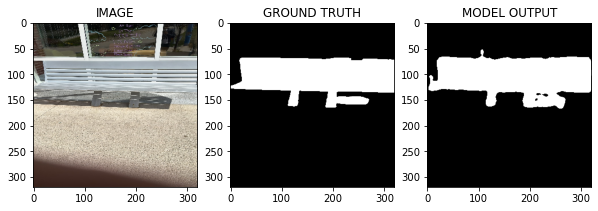

In [45]:
show_image(image, mask, pred_mask.detach().cpu().squeeze(0))


In [35]:
# import torch

In [ ]:
# import torch

# print(torch.cuda.is_available())


In [46]:
import os

folder_path = r"C:\Users\sujith kumar\Downloads\Photos (2)"  # replace with the path to your folder

for index, filename in enumerate(os.listdir(folder_path)):
    if os.path.isfile(os.path.join(folder_path, filename)):
        # append suffix to the file name
        import re
        new_filename = str(index)+'.jpg'
        # rename the file
        os.rename(os.path.join(folder_path, filename), os.path.join(folder_path, new_filename))


In [1]:
import os
import csv

# Specify the directory path containing the images
dir_path = r"C:\Users\sujith kumar\Downloads\yagna"

# Specify the file name and location to save the CSV file
csv_file = r"C:\Users\sujith kumar\Desktop\train2.csv"

# Create an empty list to store the image file paths
image_paths = []

# Iterate through the directory and append the absolute paths of the image files to the list
for filename in os.listdir(dir_path):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        image_paths.append(os.path.join('masked_images', filename))

# Write the image file paths to the CSV file
with open(csv_file, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["masks"])
    for path in image_paths:
        writer.writerow([path])


In [2]:
from GPUtil import showUtilization as gpu_usage
gpu_usage()

ModuleNotFoundError: No module named 'GPUtil'

In [37]:
torch.cuda.memory_allocated()

397283840

In [4]:

# import gc
# gc.collect()
# import torch
# torch.cuda.empty_cache()

In [5]:
# from numba import cuda
# cuda.select_device(0)
# cuda.close()
# cuda.select_device(0)

<weakproxy at 0x000001ABDDEB1900 to Device at 0x000001ABDDEB0970>

In [4]:
import cv2
import os
import numpy as np

for image_name in os.listdir(r'C:\Users\sujith kumar\Downloads\masked_images\masked_images'):
    image_path = r'C:\Users\sujith kumar\Downloads\masked_images\masked_images\{}'.format(image_name)
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

    # Check if image is None
    if image is None:
        print(f"Failed to read image {image_path}")
        continue

    # Create a binary mask where the object is white and the background is black
    mask = image[:,:,3] > 0

    # Set the object to green and the background to black in a new image
    output = np.zeros_like(image[:,:,:3])
    output[mask] = (0, 255, 0)

    # Save the output image as a JPEG file
    output_path = r'C:\Users\sujith kumar\Desktop\masked_images\{}'.format(image_name)
    cv2.imwrite(output_path, output)


Failed to read image C:\Users\sujith kumar\Downloads\masked_images\masked_images\.DS_Store


In [6]:
# del train_df, trainloader, valid_df, validloader, model


NameError: name 'train_df' is not defined

In [49]:
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH']='true'

In [47]:
!pip install rembg

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\sujith kumar\\anaconda3\\Lib\\site-packages\\~2mpy\\.libs\\libopenblas.QVLO2T66WEPI7JZ63PS3HMOHFEY472BC.gfortran-win_amd64.dll'
Consider using the `--user` option or check the permissions.




     ---------------------------------------- 23.6/23.6 MB 7.3 MB/s eta 0:00:00
     ------------------------------------- 324.5/324.5 kB 10.1 MB/s eta 0:00:00
     ---------------------------------------- 57.8/57.8 kB 1.5 MB/s eta 0:00:00
     ---------------------------------------- 82.0/82.0 kB ? eta 0:00:00
     ---------------------------------------- 6.5/6.5 MB 15.4 MB/s eta 0:00:00
  Using cached tqdm-4.65.0-py3-none-any.whl (77 kB)
     --------------------------------------- 14.9/14.9 MB 12.8 MB/s eta 0:00:00
     ---------------------------------------- 38.1/38.1 MB 5.1 MB/s eta 0:00:00
     ---------------------------------------- 47.7/47.7 kB 2.3 MB/s eta 0:00:00
     ---------------------------------------- 45.7/45.7 kB 2.4 MB/s eta 0:00:00
     -------------------------------------- 296.5/296.5 kB 9.2 MB/s eta 0:00:00
     ---------------------------------------- 96.6/96.6 kB ? eta 0:00:00
     ---------------------------------------- 42.2/42.2 MB 8.2 MB/s eta 0:00:00
  

    Uninstalling platformdirs-2.4.1:
      Successfully uninstalled platformdirs-2.4.1
  Attempting uninstall: pillow
    Found existing installation: Pillow 8.0.1
    Uninstalling Pillow-8.0.1:
      Successfully uninstalled Pillow-8.0.1
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.3
    Uninstalling numpy-1.19.3:
      Successfully uninstalled numpy-1.19.3


In [60]:
# from rembg import remove
# from PIL import Image

# input_path = 'input.jpg' # input image path
# output_path = 'output.png' # output image path




# import os

# folder_path = r"C:\Users\sujith kumar\Downloads\2023-04-09"  # replace with the path to your folder
# output = r"C:\Users\sujith kumar\Desktop\New folder"

# for index, filename in enumerate(os.listdir(folder_path)):
#     if os.path.isfile(os.path.join(folder_path, filename)):
#         # append suffix to the file name
#         import re
#         new_filename = "\\"+str(index)+'.png'
#         # rename the file
#         input = Image.open(folder_path+ filename) # load image
#         output = remove(input) # remove background
#         output.save(output+new_filename) # save image
        



ModuleNotFoundError: No module named 'rembg'